In [5]:
import wandb, torch
from ddpm_conditional import *
from fastcore.all import *

# Generation

Let's use the best model to generate samples

In [6]:
model_artifact = 'capecape/model-registry/ddpm_condtional_cifar10_64:v0'
model_artifact = 'capecape/train_sd/model:v33'

In [7]:
run = wandb.init()
artifact = run.use_artifact(model_artifact, type='model')
artifact_dir = artifact.download()

03:42:34 - ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model:v33, 356.30MB. 3 files... Done. 0:0:0.0


In [8]:
model_cpkt_path = Path(artifact_dir)

In [9]:
diff = Diffusion(img_size=config.img_size, num_classes=config.num_classes)

In [10]:
diff.load(model_cpkt_path)

In [16]:
labels = torch.ones(10).long().cuda()

In [17]:
cifar_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [18]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [19]:
samples = diff.sample(use_ema=False, labels=labels, n=len(labels))

03:45:12 - INFO: Sampling 10 new images....


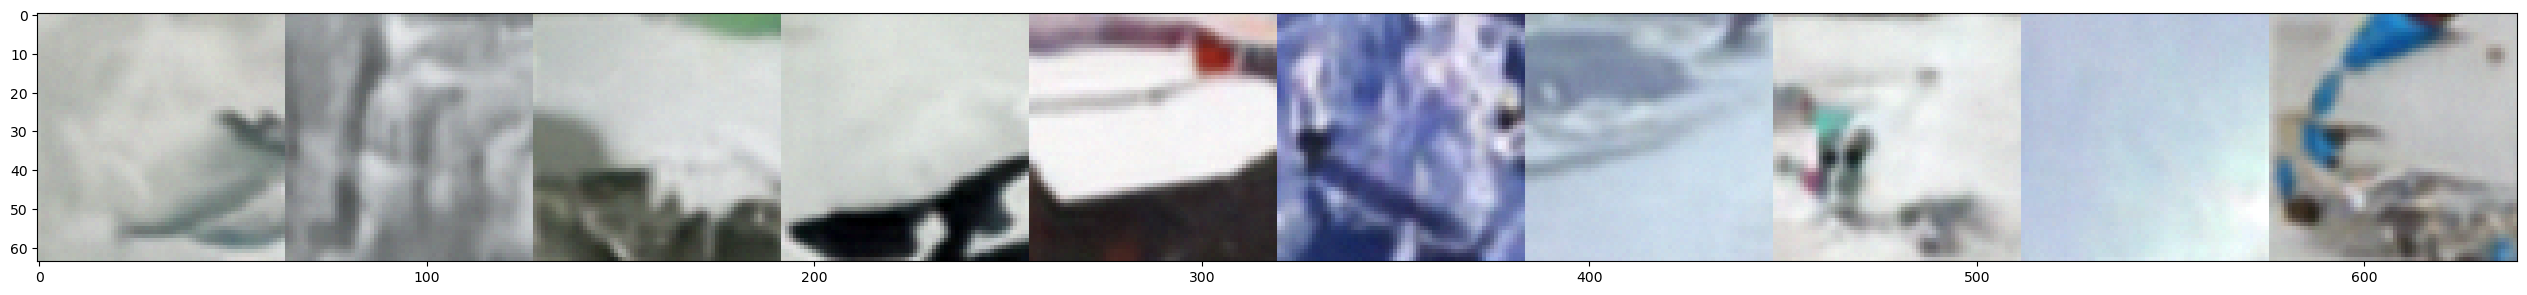

In [15]:
plot_images(samples)

## Log intermediate results?

In [23]:
@patch
@torch.inference_mode()
def sample_intermediate(self:Diffusion, use_ema, labels, cfg_scale=3):
    n = len(labels)
    model = self.ema_model if use_ema else self.model
    model.eval()
    with torch.inference_mode():
        x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
        for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
            t = (torch.ones(n) * i).long().to(self.device)
            predicted_noise = model(x, t, labels)
            if cfg_scale > 0:
                uncond_predicted_noise = model(x, t, None)
                predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            wandb.log({"gens": wandb.Image(x)})
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

In [24]:
with wandb.init(project="train_sd", job_type="generation", config=config):
    samples = diff.sample_intermediate(True, labels=labels)
    plot_images(samples)